# COVID-19 Segmentation TC3006C Advanced Artificial Intelligence for Data Science I

**Members**
<br>
Fabián Erubiel Rojas Yañez - A01706636
<br>
Jorge Martínez López - A01704518
<br>
José Emiliano Riosmena Castañón - A01704245
<br>
Gamaliel Marines Olvera - A01708746

Para mantener la privacidad y confidencialidad de los datos de los pacientes, nuestros datos son anónimos.

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/tools/templates/notebook.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /><br>Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/tools/templates/notebook.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/tools/templates/notebook.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>

</table>

In [4]:
!pip install segmentation_models_pytorch

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [6]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content


# CARGAR LOS ARCHIVOS

## Medseg part
Se trata de un conjunto de datos de 100 imágenes de TC axial de más de 40 pacientes con COVID-19 que se convirtieron a partir de imágenes JPG
* images_medseg
  - Imágenes de entrenamiento – 100 cortes de tamaño 512x512
* masks_medseg
  - Máscaras de entrenamiento – 100 máscaras4 canales:
    - 0 - "vidrio esmerilado"
    - 1 - "consolidaciones"
    - 2 - "pulmones otros"
    - 3 - "fondo"

## Radiopedia part
Son 9 tomografías computarizadas volumétricas axiales segmentadas de Radiopaedia . Este conjunto de datos incluye volúmenes completos y, por lo tanto, incluye cortes positivos y negativos (373 de un total de 829 cortes han sido evaluados por un radiólogo como positivos y segmentados).

* images_radiopedia
  - imágenes de entrenamiento – 829 cortes de tamaño 512x512
  
* masks_radiopedia
  - máscaras de entrenamiento – 829 máscaras con 4 canales:
    - 0 - "vidrio esmerilado"
    - 1 - "consolidaciones"
    - 2 - "pulmones otros"
    - 3 - "fondo"

In [7]:
prefix = '/content/gdrive/MyDrive/AI/DataSet'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

Formato de las imagenes(#1, #2, #3, #4):

1. Número total de imágenes o máscara
2. Altura de cada imagen o máscara
3. Anchura de cada imagen o máscara
4. Canal



In [8]:
print('Img Radiopedia',images_radiopedia.shape)
print('Masks Radiopedia',masks_radiopedia.shape)
print('Img Med',images_medseg.shape)
print('Masks Med',masks_medseg.shape)

Img Radiopedia (829, 512, 512, 1)
Masks Radiopedia (829, 512, 512, 4)
Img Med (100, 512, 512, 1)
Masks Med (100, 512, 512, 4)


<hr>

# Visualización Imagen contra máscara
Define una función llamada visualize que recibe cinco parámetros:

* **image_batch:** conjunto de imágenes que se van a visualizar.
* **mask_batch:** opcional, máscaras asociadas a las imágenes (útil para segmentación).
* **pred_batch:** opcional, predicciones de las máscaras.
* **num_samples:** número de muestras que se van a mostrar (por defecto 8).
* **hot_encode:** si es True, se asume que los datos están en formato de codificación one-hot.



In [9]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
  """
  Función para visualizar imágenes, máscaras y predicciones (opcional)
  Parámetros:
  - image_batch: batch de imágenes a visualizar.
  - mask_batch: batch de máscaras correspondientes a las imágenes (opcional).
  - pred_batch: batch de predicciones correspondientes a las imágenes (opcional).
  - num_samples: número de muestras a visualizar. Por defecto es 8.
  - hot_encode: si es True, asume que las imágenes son codificadas en una sola canal (grises).
  """

  # Determina el número de clases basadas en la última dimensión de las máscaras, si están presentes
  num_classes = mask_batch.shape[-1] if mask_batch is not None else 0

  # Crea una figura con subplots. El número de filas es el número de clases + 1 (para la imagen original).
  # El número de columnas es igual al número de muestras.
  fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

  # Recorre las muestras a visualizar
  for i in range(num_samples):
      # Selecciona el eje correspondiente a la imagen original (primera fila)
      ax_image = ax[0, i] if num_classes > 0 else ax[i]

      # Muestra la imagen en escala de grises si hot_encode es True
      if hot_encode:
          ax_image.imshow(image_batch[i, :, :, 0], cmap='Greys')  # Imagen en escala de grises
      else:
          ax_image.imshow(image_batch[i, :, :])  # Imagen en RGB o similar
      ax_image.set_xticks([])  # Oculta los ticks del eje X
      ax_image.set_yticks([])  # Oculta los ticks del eje Y

      # Si se proporciona una máscara, se visualiza
      if mask_batch is not None:
          # Itera sobre las clases, limitando para que j no exceda la profundidad de la máscara
          for j in range(min(num_classes, mask_batch.shape[-1])):
              if pred_batch is None:
                  # Si no hay predicciones, muestra la máscara original
                  mask_to_show = mask_batch[i, :, :, j]
              else:
                  # Si hay predicciones, combina la predicción con la máscara original
                  mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))  # Imagen vacía RGB
                  mask_to_show[..., 0] = pred_batch[i, :, :, j] > 0.5  # Canal rojo para la predicción (umbral)
                  mask_to_show[..., 1] = mask_batch[i, :, :, j]  # Canal verde para la máscara original
              # Muestra la máscara/predicción en la figura
              ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
              ax[j + 1, i].set_xticks([])  # Oculta los ticks del eje X
              ax[j + 1, i].set_yticks([])  # Oculta los ticks del eje Y

  # Ajusta el diseño de la figura para que los subplots no se superpongan
  plt.tight_layout()
  # Muestra la figura completa
  plt.show()

#Visualización de las imagenes
* NIVEL 1: Imagen
* NIVEL 2: Clase 0 - "vidrio esmerilado"
* NIVEL 3: Clase 1 - "consolidaciones"
* NIVEL 4: Clase 2 - "pulmones otros"
* NIVEL 5: Clase 3 - "fondo"
  

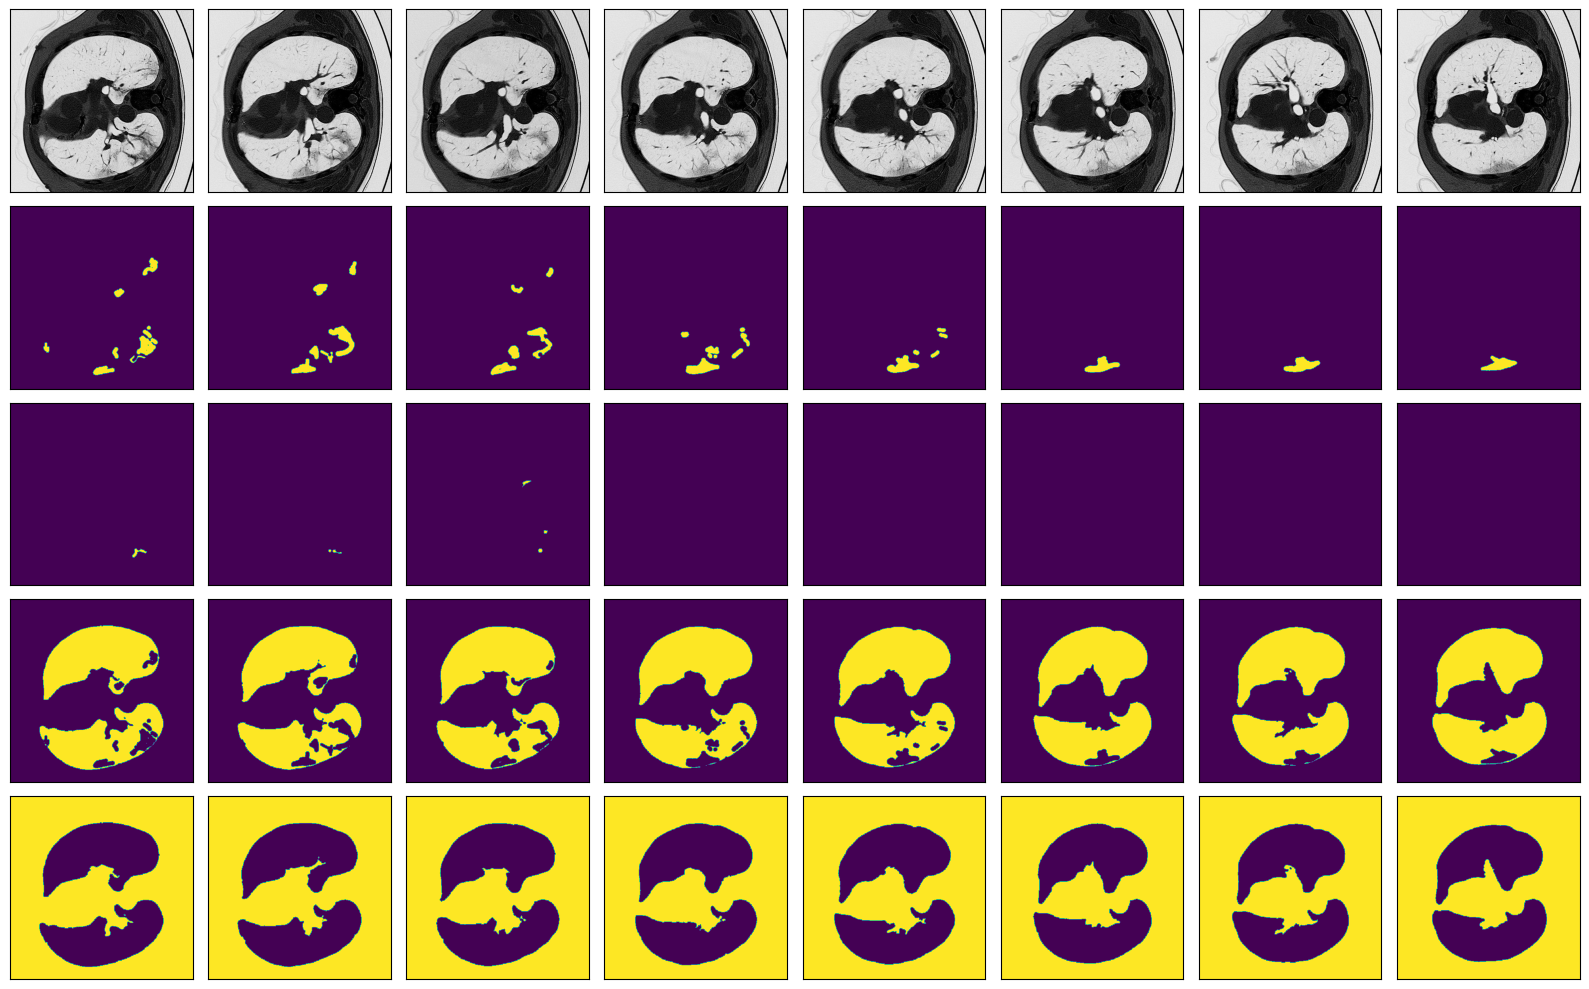

In [10]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

## Importancia de One-Hot
---
Permite la lectura de la data, en este caso las imagenes.

### Implementación de la función One-Hot
* Clase 0: [1, 0, 0, 0] → Color 0
* Clase 1: [0, 1, 0, 0] → Color 1
* Clase 2: [0, 0, 1, 0] → Color 2
* Clase 3: [0, 0, 0, 1] → Color 3


In [11]:
# Definición de la función onehot_to_mask
def onehot_to_mask(mask, palette):
    """
    Esta función convierte una máscara codificada one-hot con forma (H, W, K) a una máscara con forma (H, W, C) utilizando una paleta de colores palette.
    H y W son la altura y el ancho de la máscara
    K es el número de clases (profundidad del one-hot)
    C es el número de canales que codifican un color (en este caso 1, 2 o 3)
    """
    # El resultado es un array x de tamaño (H, W) que contiene el índice de la clase más probable para cada píxel
    x = np.argmax(mask, axis=-1)
    # Se convierte la paleta palette en un array de NumPy, con el fin de mapeo de clases por color
    colour_codes = np.array(palette)
    # Esto asigna un valor de color (especificado en la paleta) a cada píxel en función del índice de clase.
    # Por ejemplo, si x[i, j] == 2, el valor correspondiente en palette será 2 (el valor de la paleta en el índice 2).
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    print(x)
    return x

# Previsualización de las clases

In [12]:
#  hay 4 clases representadas por los valores negro, rojo, verde y azul.
#palette = [[0, 0, 0], [255, 0, 0], [0, 255, 0],[0, 0, 255]]
palette = [[0], [1], [2],[3]]

# Convierte las máscaras one-hot en una representación paletizada.
# Squeeze elimina las dimensiones de tamaño 1 innecesarias, lo que asegura que las máscaras resultantes tengan forma (H, W)
# Entrenamiento color
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
# Entrenamiento color
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

# Visualización
# visualize(masks_medseg_recover[1],hot_encode=False)

[[[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 ...


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]

<hr>

# Normalización de las imagenes
---
* La normalización de imágenes es fundamental porque garantiza que los datos de entrada tengan un rango de valores consistente, lo que ayuda a estabilizar y acelerar el proceso de entrenamiento.

* Al escalar las intensidades de los píxeles para que tengan una media de cero y una desviación estándar de uno, se evita que algunas características dominen sobre otras debido a diferencias en las magnitudes de los valores de los píxeles.

* Esto facilita que la red neuronal aprenda patrones y características relevantes de las imágenes de manera más efectiva, mejorando tanto la velocidad de convergencia como el rendimiento general del modelo.


## 1. Clipping de Valores Extremos

Se establece un rango de valores permitidos para las imágenes, fijando un valor máximo de 500 y un valor mínimo de -1500.


$$
\text{images_arr} =
\begin{cases}
  500 & \text{si } \text{images_arr} > 500 \\
  -1500 & \text{si } \text{images_arr} < -1500 \\
  \text{images_arr} & \text{en otro caso}
\end{cases}
$$
## 2. Cálculo de Percentiles

 De 5% y el 95% de los datos caen por debajo de estos puntos.
$$
P_5 = \text{percentil 5 de images_arr} \\
P_{95} = \text{percentil 95 de images_arr}
$$
<br>
Los valores entre los percentiles 5 y 95 se seleccionan para excluir los valores más bajos y más altos.
$$
\text{images_arr_valid} = \{x \in \text{images_arr} \mid P_5 < x < P_{95}\}
$$
## 3. Cálculo de Media y Desviación Estándar

Si no se proporciona una media y desviación estándar externas (`mean_std`), se calculan a partir de los valores dentro del rango de percentiles.

- La **media** μ se define como:
$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
donde \(x_i\) son los valores de `images_arr_valid` y \(n\) es el número total de esos valores.

- La **desviación estándar** (\(\sigma\)) se calcula como:

 $$ sigma = sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \mu)^2}$$


## 4. Normalización

Cada valor de la imagen se ajusta para tener una media de 0 y una desviación estándar de 1.

$$
\text{images_arr_norm} = \frac{\text{images_arr} - \mu}{\sigma}
$$

Donde **μ** es la media y **sigma** es la desviación estándar calculadas previamente.

## 5. Resultado

Finalmente, el array normalizado junto con la media y la desviación estándar calculadas se devuelven como salida del proceso.



    

In [13]:
def preprocess_images(images_arr, mean_std=None):
    # Clipping de valores extremos
    # Se reemplazan todos los valores mayores a 500 por 500 y todos loss valores menores a -1500 por -1500.
    # Con la finalidad de sesgar grandes o pequeños puedan sesgar la media o la desviación
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500

    # Calculo de percentiles 5 y 95
    # Los percentiles son puntos en una distribución donde un porcentaje de los datos cae por debajo de ese valor
    # El percentil 5 es el valor debajo del cual se encuentran el 5% de los datos, y el percentil 95 es el valor por encima del cual se encuentra el 5% superior
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    # Filtrado del rango dentro de los percentiles, estamos excluyendo 10%, 5 a 95
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    # Calculamos la desviación estándar y la mediana
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    # Normalizamos con la desviación estándar
    # (media 0, desviación estándar 1)
    images_arr = (images_arr - mean) / std
    # Mostramos los valores
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

In [14]:
# Samples transformación de los datos
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


**Media negativa:** En imágenes médicas, especialmente en tomografías, los valores de píxel suelen estar en unidades Hounsfield (HU). El aire tiene un valor alrededor de -1000 HU, la grasa tiene valores cercanos a -100 HU, el agua tiene un valor cercano a 0 HU, y los huesos pueden tener valores positivos altos. Un valor promedio de -451.65 sugiere que el conjunto de datos tiene muchas regiones con aire o materiales de baja densidad. <br>
**Desviación estándar alta:** Esto indica una gran variabilidad en la intensidad de los píxeles, lo cual es típico en imágenes médicas donde diferentes tejidos (aire, grasa, hueso, etc.) tienen distintas densidades y, por lo tanto, diferentes valores de píxel.

<hr>

# Distribución de las imagenes

### ¿Por qué Histograma?
---
Porque proporciona una visualización de la distribución de las intensidades de los píxeles. Esto ayuda a identificar características importantes como el contraste, el brillo, la presencia de artefactos o ruido, y posibles desbalances en los datos. Al analizar el histograma, se pueden detectar problemas en la calidad de las imágenes, como niveles de exposición inadecuados o variaciones que podrían afectar el rendimiento de la red neuronal.

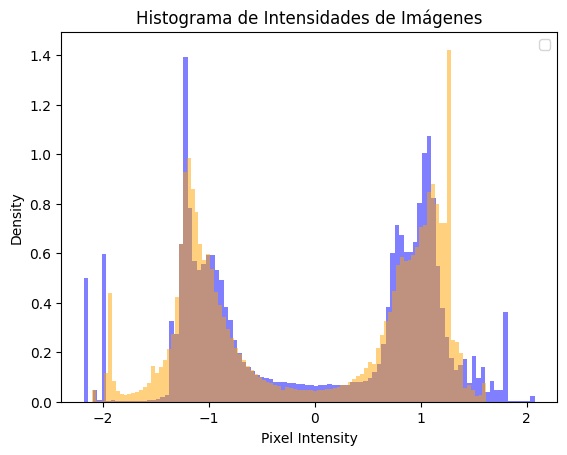

In [15]:
def plot_hists(images1, images2=None):
  """
  Función para graficar histogramas de intensidades de píxeles de una o dos series de imágenes.
  Parámetros:
  - images1: Primer set de imágenes para graficar el histograma.
  - images2: Segundo set de imágenes opcional, para comparar su histograma con el del primer set.
  """

  """
  Graficar histograma del primer set de imágenes.
  'ravel()' aplana la matriz de imágenes en un arreglo unidimensional.
  'bins=100' divide las intensidades en 100 intervalos (bins).
  'density=True' normaliza el histograma para representar la densidad en lugar del conteo absoluto.
  'color' define el color de la gráfica (azul para images1).
  'alpha' controla la transparencia, permitiendo ver superposición si se grafican dos conjuntos de imágenes.
  """
  plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)

  # Si se proporciona un segundo conjunto de imágenes, se grafica también su histograma.
  if images2 is not None:
      # El histograma de images2 se grafica en color naranja y con transparencia (alpha=0.5).
      plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')

  # Añadir etiquetas y leyenda a la gráfica
  plt.xlabel('Pixel Intensity')  # Etiqueta para el eje X, representando la intensidad de los píxeles
  plt.ylabel('Density')  # Etiqueta para el eje Y, representando la densidad de píxeles
  plt.legend(loc='best')  # Añade una leyenda que indica los conjuntos de imágenes (ubicación automática)
  plt.title('Histograma de Intensidades de Imágenes')  # Título de la gráfica

  # Mostrar la gráfica

  plt.show()

# Graficar los histogramas de dos conjuntos de imágenes
plot_hists(test_images_medseg, images_radiopedia)

<hr>


# Split Train / Split
### Secuencia del código
1. Aplicamos onehot a las máscaras
2. Tamaños de los set de val y train
3. Concatenamos las imagenes y máscaras de resonancias magnéticas con tomografías computarizadas para los set de entrenamiento
4. Dividimos la dataset resonancia magnética de máscara y imagen para conformar nuestro set val
5. Creamos los tamaños de batch para entrenamiento
6. Liberamos memoria



In [16]:
# Conversión de máscaras one-hot a máscaras de colores
# Función one-hot-encoding, el resultado formato (H,W)
# Convertimos las maskaras a color del palette
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Separación de los índices para entrenamiento y validación
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

# One-hot a mask en tareas de segmentación de imágenes se realiza principalmente para convertir
# la representación matricial de varias clases (canales) en una imagen con valores discretos o colores
# Se concatenan las máscaras correspondientes en train_masks.
# Concatenar tanto las imágenes como las máscaras asegura que el modelo pueda entrenarse adecuadamente en el conjunto completo de imágenes con sus respectivas etiquetas.

# Concatenación de imágenes y máscaras para entrenamiento y validación
# Preparamos nuestra data de entrenamiento para que el modelo pueda detectar en resonancias
train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))

# Separamos las imagenes con las de validación
val_images = images_medseg[val_indexes]
# Separamos las mascaras con las de validación
val_masks = masks_medseg_recover[val_indexes]

# Tamaño de los lotes
batch_size = len(val_masks)

# Liberar memoria y evitar problemas de consumo innecesario.
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

[[[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  ...

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]

  [[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]]]


 ...


 [[[3]
   [3]
   [3]
   ...
   [3]
   [3]
   [3]

<hr>

**LIBRERIAS** <br>
Tensorflow para la creación de modelos de machine learning <br>
Albumetations para manipulación de imagen <br>
CV2 para procesamiento de imagen
<br><br>
**Sección 1** <br>
Sintéticamente aumentamos la cantidad de datos de train, variaciones de img. original
  - Rotación de -369 y +369
  - Recortamos área entre el 75% del tamaño original
  - Redimensión 256x256
  - Interpolación (INTER_NEAREST)
  - Horizontal (50%) <br>

**Sección 2** <br>
Sintéticamente aumentamos la cantidad de datos de val, variaciones de img. original
  - Redimensión 256x256
  - Interpolación (INTER_NEAREST)

El obejtivo de esto es poder enriquecer los datos con variaciones que hacen que el modelo sea más robusto frente a diferentes condiciones de imagen.

In [17]:
import tensorflow # Machine learning
import albumentations # Manipulación  de imagen
import cv2 # Procesamiento de imagen

# Tamaño original de las imágenes
SOURCE_SIZE = 512
# Tamaño de destino al que se ajustarán las imágenes
TARGET_SIZE = 256

# Aumentaciones de imágenes para el conjunto de entrenamiento
train_augs = albumentations.Compose([
    # Rotar la imagen de manera aleatoria entre -369 y +369 grados con una probabilidad de 90%.
    # El borde de la imagen se replica para rellenar los espacios vacíos tras la rotación.
    albumentations.Rotate(limit=369, p=0.9, border_mode=cv2.BORDER_REPLICATE),

    # Recorte aleatorio de las imágenes.
    # Se recorta un área entre el 75% del tamaño original y el tamaño completo de la imagen,
    # y luego se redimensiona a TARGET_SIZE x TARGET_SIZE.
    # La interpolación "INTER_NEAREST" se utiliza para preservar bordes duros (importante en máscaras).
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE),
                                   TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST),

    # Volteo horizontal aleatorio con una probabilidad de 50%.
    albumentations.HorizontalFlip(p=0.5),
])

# Aumentaciones para el conjunto de validación (normalmente menos agresivas que en entrenamiento).
val_augs = albumentations.Compose([
    # Redimensionar las imágenes a TARGET_SIZE x TARGET_SIZE sin realizar ninguna otra transformación.
    # Se utiliza la misma interpolación que en el conjunto de entrenamiento para consistencia.
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST),
])

In [18]:
!pip show torch

Name: torch
Version: 2.4.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: accelerate, efficientnet_pytorch, fastai, pretrainedmodels, timm, torchaudio, torchvision


<hr>


#Sección de creación de Dataset

Se crea una dataset clase, y su finalidad es poder manerja más eficiente los datos con la librerias de deep learning. Pytorch cuenta con métodos __getitem__() y __len__(), que permite la integración a la DataLoader para el manejo de la data durante el entrenamiento.

A su vez, hacer más sencillo encapsular la lógica de manejo de datos (cargar imágenes, máscaras, realizar transformaciones, etc.) en una sola estructura. Esto hace que el código sea más modular y fácil de reutilizar en diferentes proyectos o experimentos.


**LIBRERIAS**<br>
Deep Learning <br>
*  segmentation_models_pytorch
* torch.nn.functional
* torch.nn
* torchvision
* torch.util.data
* torch

Imagen
* PIL

Herramientas
* time
* tqdm.notebook


In [19]:
from PIL import Image  # Librería para abrir y manipular imágenes.
import segmentation_models_pytorch as smp  # Modelos preentrenados para segmentación.
import torch.nn.functional as F  # Funciones útiles para redes neuronales en PyTorch.
import torch.nn as nn  # Componentes básicos para construir redes neuronales en PyTorch.
from tqdm.notebook import tqdm  # Para mostrar barras de progreso en notebooks.
import time  # Para medir el tiempo de ejecución.

from torchvision import transforms as T  # Transformaciones comunes de imágenes en PyTorch.
from torch.utils.data import Dataset, DataLoader  # Para crear datasets y dataloaders en PyTorch.
import torch  # Biblioteca principal de PyTorch.

### Activación de la GPU
Si está disponible CUDA lo activamos  si no siguimos trabajando con la CPU.
Y testiamos si el tensor está trabajando la GPU

In [20]:

# Comprobar si CUDA (GPU) está disponible
print(torch.cuda.is_available())  # Debería devolver True si hay GPU disponible

# Establecer el dispositivo en el que se ejecutarán las operaciones (CUDA si está disponible, de lo contrario CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ejemplo de operaciones con tensores en GPU
x = torch.rand(5, 5).to(device)  # Crear un tensor aleatorio y moverlo a la GPU
print(x.device)  # Debería imprimir "cuda:0" si el tensor está en la GPU

False
cpu


### Construcción de la dataset clase
**MÉTODOS**
* __init__ → Inicializar con imágenes, máscaras y posibles aumentaciones
* __getitam__ → Transformar las imagen y máscara a tensor, devuelve máscara y imagen tensorizadas
* __len__ → Retornar el tamaño del dataset (número de imágenes)
* __tiles__→ Dividir la imagen y la máscara en pequeños parches (tiles)


In [21]:


# Definir la clase personalizada para el dataset
class Dataset:
    def __init__(self, images, masks, augentations=None):
        # Inicializar con imágenes, máscaras y posibles aumentaciones
        self.images = images
        self.masks = masks
        self.argumentations = augentations
        # Definir la media y desviación estándar para normalización, imagenNet
        self.mean = [0.485]
        self.std = [0.229]

    def __getitem__(self, i):
        # Obtener una imagen y su máscara correspondiente por índice
        image = self.images[i]
        mask = self.masks[i]
        # Si hay aumentaciones definidas, aplicarlas
        if self.argumentations is not None:
            augmentations = self.argumentations(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        # Si no hay aumentaciones, convertir la imagen en un formato de PIL
        if self.argumentations is None:
            image = Image.fromarray(image)

        # Definir las transformaciones: convertir a tensor y normalizar
        t = T.Compose([
            T.ToTensor(),  # Convertir la imagen a tensor
            T.Normalize(self.mean, self.std)  # Normalizar con la media y desviación estándar
        ])
        image = t(image)  # Aplicar las transformaciones a la imagen
        mask = torch.from_numpy(mask).long()  # Convertir la máscara a tensor de enteros largos (para clasificación)
        return image, mask  # Devolver la imagen y la máscara como tensores

    def __len__(self):
        # Retornar el tamaño del dataset (número de imágenes)
        return len(self.images)

    # Método para dividir la imagen y la máscara en pequeños parches (tiles)
    def tiles(self, image, mask):
        # Dividir la imagen en parches de tamaño 512x768
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)  # Reorganizar las dimensiones

        # Dividir la máscara en parches de tamaño 512x768
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        # Devolver los parches de la imagen y la máscara
        return img_patches, mask_patches



### Creación de una dataset para train y val
1. Creamos nuestro constructor para cada set
  - Entrenamiento
    - Imagen
    - Mask
    - Imagenes sintétizados
  - Prueba
    - Imagen
    - Mask
    - Imagenes sintétizados
2. Cargamos nuestros sets a un dataloader de Pytorch y revolvemos los datos de entrenaimento


In [22]:
# Crear el dataset de entrenamiento con imágenes, máscaras y aumentaciones
train_dataset = Dataset(train_images, train_masks, train_augs)

# Crear el dataset de validación con imágenes, máscaras y aumentaciones de validación
val_dataset = Dataset(val_images, val_masks, val_augs)

# Crear dataloaders para cargar datos en lotes (batch_size) para entrenamiento y validación
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Barajar datos de entrenamiento
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No barajar datos de validación

<hr>

# Mask a One-hot
Se crea una función para convertir de color de las máscaras a labels binarias, con el fin de poder procesarlos con tensorflow.

In [23]:
def mask_to_onehot(mask, palette):
    """
    Convierte una máscara de segmentación (H, W, C) a (H, W, K) donde la última dimensión es un vector one-hot.
    mask: La máscara de entrada, se espera que tenga la forma (batch_size, height, width, channels).
    palette: La paleta que contiene los valores RGB para cada clase.
    """
    # Crear un mapa semántico para representar las clases en forma one-hot
    semantic_map = []

    # Iterar sobre cada color (clase) en la paleta
    for colour in palette:
        # Comparar cada píxel de la máscara con el color actual de la paleta (verificando en los 3 canales RGB)
        equality = np.all(mask == np.array(colour).reshape(1, 1, -1), axis=-1)  # Verifica igualdad en cada canal (RGB)

        # Agregar el resultado de la comparación (True/False) al mapa semántico
        semantic_map.append(equality)

    # Apilar todos los mapas semánticos a lo largo de un nuevo eje para formar la codificación one-hot
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)

    # Convertir la matriz de numpy a un tensor de PyTorch
    return torch.from_numpy(semantic_map)



### Mask to Onehot
1. Numeramos los batch de nuestra dataloader
2. Convertimos de mask de color a one-hot por clase
3. One-hot a tensor


In [24]:
# Obtener el primer lote de datos de entrenamiento desde el dataloader
i, train_data = next(enumerate(train_dataloader))
print(train_data[0].shape)  # Imprimir la forma de las imágenes de entrada
print(train_data[1].shape)  # Imprimir la forma de las máscaras

# Convertir la máscara a formato one-hot usando la función `mask_to_onehot`
mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1], -1).numpy(), palette)

# Visualizar las imágenes y máscaras (esta parte está comentada, pero sirve para hacer la visualización si se necesita)
# visualize(torch.unsqueeze(torch.squeeze(train_data[0], 1), -1), mask_hot_encoded)
# visualize(train_data[0].permute(0, 2, 3, 1), mask_hot_encoded)

# Imprimir las formas de las imágenes y de las máscaras codificadas en one-hot
print("Image shape:", train_data[0].permute(0, 2, 3, 1).shape)  # Reorganiza las dimensiones para visualización
print("Mask one-hot shape:", mask_hot_encoded.shape)  # Forma de la máscara codificada

torch.Size([24, 1, 256, 256])
torch.Size([24, 256, 256])
Image shape: torch.Size([24, 256, 256, 1])
Mask one-hot shape: torch.Size([24, 256, 256, 4])


<hr>

# pixel_accuracy Function

## Descripción

La función `pixel_accuracy` calcula la precisión por píxel para evaluar el rendimiento de un modelo de segmentación de imágenes. Esta métrica mide la proporción de píxeles en los cuales la predicción del modelo coincide con la verdad de terreno.

- **output**: La salida del modelo, que contiene las probabilidades para cada clase en cada píxel.
- **mask**: La máscara de verdad de terreno (ground truth), que contiene las clases correctas para cada píxel.

## Explicación Matemática

La **precisión por píxel** se define como:

$$
\text{Precisión por píxel} = \frac{\text{Número de píxeles correctos}}{\text{Número total de píxeles}}
$$

donde:

- **Número de píxeles correctos** es el número de píxeles en los que la clase predicha por el modelo coincide con la clase verdadera en la máscara.
- **Número total de píxeles** es el número total de píxeles en la imagen.

### Proceso de Cálculo

1. **Obtener la Predicción de Clase**:
   - La salida del modelo (`output`) se pasa a través de la función softmax para obtener las probabilidades para cada clase.
   - La clase con la probabilidad máxima se selecciona como la predicción final para cada píxel.

2. **Comparar la Predicción con la Verdad de Terreno**:
   - Se compara la predicción del modelo con la máscara verdadera para cada píxel.
   - Se crea un tensor que indica si la predicción coincide con la verdad de terreno (1 si son iguales, 0 si no).

3. **Calcular la Precisión**:
   - La precisión por píxel se calcula como la proporción de píxeles correctos sobre el número total de píxeles.



In [25]:
def pixel_accuracy(output, mask):
    """
    Calcula la precisión por píxel entre la predicción de salida y la máscara de referencia.
    output: La salida del modelo, que tiene una dimensión de clase en el índice 1.
    mask: La máscara de verdad de terreno (ground truth), con las clases correctas por píxel.
    """
    with torch.no_grad():  # Desactiva el cálculo del gradiente, ya que no es necesario para la evaluación
        # Aplica softmax para obtener probabilidades a partir de la salida del modelo y luego toma la clase con mayor probabilidad
        output = torch.argmax(F.softmax(output, dim=1), dim=1)

        # Compara la salida predicha con la máscara verdadera para cada píxel (devuelve 1 si son iguales, 0 si no)
        correct = torch.eq(output, mask).int()  # .int() convierte el tensor booleano en un tensor de enteros (1 y 0)

        # Calcula la precisión dividiendo el número de píxeles correctos por el número total de píxeles
        accuracy = float(correct.sum()) / float(correct.numel())

    # Devuelve la precisión por píxel
    return accuracy

<hr>


# mIoU Función

## Descripción

La función `mIoU` (mean Intersection over Union) calcula la media de la Intersección sobre la Unión para una predicción de segmentación en un problema de **segmentación de imágenes**. La mIoU es una métrica comúnmente utilizada para evaluar el rendimiento de modelos de segmentación semántica.

- **pred_mask**: Máscara de predicción del modelo, con la dimensión de clase en el índice 1.
- **mask**: Máscara de verdad de terreno (ground truth) con las clases correctas por píxel.
- **smooth**: Valor pequeño añadido para evitar división por cero en el cálculo de IoU.
- **n_classes**: Número total de clases en la segmentación.

## Explicación Matemática

La **Intersección sobre la Unión (IoU)** para una clase específica se define como:

$$
\text{IoU} = \frac{\text{Área de Intersección}}{\text{Área de Unión}}
$$

donde:

- **Intersección** (Área de Intersección): Número de píxeles que están en la región de predicción y en la verdad de terreno para la clase(i).
- **Unión** (Área de Unión): Número de píxeles que están en la región de predicción o en la verdad de terreno para la clase(i).

La fórmula general para la media de la Intersección sobre la Unión (mIoU) es:

$$
\text{mIoU} = \frac{1}{n_{\text{classes}}} \sum_{i=0}^{n_{\text{classes}}-1} \text{IoU}
$$

donde n  es el número total de clases.

### Proceso de Cálculo

1. **Obtener Predicciones de Clases**:
   - La máscara de predicción del modelo (`pred_mask`) se pasa a través de una función softmax para obtener probabilidades de clase.
   - La clase con la probabilidad máxima se selecciona como la predicción final.

2. **Aplanar las Máscaras**:
   - Tanto la máscara de predicción como la verdad de terreno se aplanan para simplificar los cálculos.

3. **Calcular IoU para Cada Clase**:
   - Para cada clase, se crean máscaras binarias para la clase actual en las predicciones y en la verdad de terreno.
   - Se calcula la intersección y la unión entre la máscara de predicción y la máscara de verdad de terreno para cada clase.
   - Se calcula IoU utilizando la fórmula:

     $$
     \text{IoU} = \frac{\text{Intersección} + \text{smooth}}{\text{Unión} + \text{smooth}}
     $$

   - Se añade un valor pequeño (`smooth`) para evitar la división por cero.

4. **Calcular la Media de IoU**:
   - La media de IoU se calcula promediando los valores de IoU obtenidos para cada clase, ignorando cualquier valor NaN si no hay píxeles de la clase en la verdad de terreno.



In [26]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    """
    Calcula la media de la Intersección sobre la Unión (mIoU) para una predicción de segmentación.
    pred_mask: La máscara de predicción del modelo, con la dimensión de clase en el índice 1.
    mask: La máscara de verdad de terreno (ground truth) con las clases correctas por píxel.
    smooth: Valor pequeño añadido para evitar división por cero en el cálculo de IoU.
    n_classes: Número total de clases en la segmentación.
    """
    with torch.no_grad():  # Desactiva el cálculo del gradiente para eficiencia en la evaluación
        # Aplica softmax para obtener probabilidades y luego selecciona la clase con mayor probabilidad
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)

        # Aplana las máscaras para simplificar los cálculos
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []  # Lista para almacenar el IoU por clase

        # Itera sobre cada clase para calcular el IoU
        for clas in range(0, n_classes):
            # Crea una máscara binaria para la clase actual en las predicciones y la verdad
            true_class = pred_mask == clas
            true_label = mask == clas

            # Si no hay píxeles de la clase actual en la verdad de terreno, se asigna NaN
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                # Calcula la intersección y la unión para la clase actual
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                # Calcula el IoU con un pequeño valor de suavizado para evitar la división por cero
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)

        # Calcula y devuelve la media de IoU, ignorando NaN
        return np.nanmean(iou_per_class)

In [27]:
def iou(pred, gt):
    """
    Calcula el Índice de Intersección sobre la Unión (IoU) entre la predicción y la verdad de terreno.
    pred: Tensor de predicción del modelo con la forma [batch_size, height, width].
    gt: Tensor de verdad de terreno (ground truth) con la misma forma que pred.
    """
    # Elimina dimensiones de tamaño 1 (si las hay) y mueve los tensores a la CPU
    pred = pred.squeeze().cpu().data.numpy()
    gt = gt.squeeze().cpu().data.numpy()

    # Convierte las predicciones en etiquetas de clase (esto depende de cómo esté implementado ToLabel)
    pred = ToLabel(pred)

    # Agrega la predicción y la verdad de terreno para calcular la intersección y la unión
    agg = pred + gt

    # Calcula la intersección: píxeles que son 1 en ambas (predicción y verdad de terreno)
    i = float(np.sum(agg == 2))

    # Calcula la unión: cualquier píxel que sea 1 en al menos uno de los dos (predicción o verdad de terreno)
    u = float(np.sum(agg > 0))

    # Calcula IoU, maneja el caso cuando no hay píxeles en la unión
    if u == 0:
        result = 1  # Retorna 1 si no hay píxeles en la unión para evitar división por cero
    else:
        result = i / u

    return result

<hr>


# U-Net for Image Classification

## Descripción del Modelo U-Net

U-Net es una arquitectura de red neuronal profunda especialmente diseñada para tareas de segmentación de imágenes, aunque también puede adaptarse a tareas de clasificación de imágenes. Desarrollada originalmente para segmentación biomédica, U-Net ha demostrado ser altamente efectiva en tareas que requieren segmentación precisa a nivel de píxel.

### Estructura del Modelo U-Net

La arquitectura U-Net se basa en una estructura de codificación y decodificación simétrica:

1. **Codificación (Downsampling)**:
   - La parte de codificación del U-Net es una serie de capas convolucionales que capturan características de alto nivel de la imagen.
   - Cada etapa de codificación se compone de dos bloques de convolución seguidos de una operación de max pooling.
   - Las características extraídas se reducen a medida que avanzamos hacia la profundidad de la red, extrayendo características cada vez más abstractas.

2. **Puente (Bottleneck)**:
   - En el centro de la red, se encuentra el puente, donde las características están en su forma más comprimida. Aquí se realiza la convolución para integrar información a nivel más profundo.

3. **Decodificación (Upsampling)**:
   - La parte de decodificación recupera la resolución original de la imagen utilizando operaciones de upsampling y convoluciones.
   - Cada etapa de decodificación utiliza características combinadas de la parte de codificación correspondiente mediante concatenaciones para preservar detalles espaciales.

4. **Conexiones de Salida (Skip Connections)**:
   - Las conexiones skip entre la parte de codificación y decodificación permiten la transferencia directa de información, ayudando a preservar detalles espaciales y mejorar la precisión de la segmentación.

5. **Capa de Salida**:
   - La capa final del U-Net aplica una convolución 1x1 para mapear las características a las clases finales de segmentación o clasificación, ajustando el número de filtros a las clases deseadas.

## Cómo Funciona el Modelo U-Net para Clasificación de Imágenes

Para clasificación de imágenes, U-Net puede ser adaptado de la siguiente manera:

1. **Preparación de Datos**:
   - Las imágenes se preparan y se etiquetan para la tarea de clasificación. La salida de cada píxel en la capa final representa la clase a la que pertenece el píxel.

2. **Adaptación de la Capa de Salida**:
   - En lugar de la típica capa de salida para segmentación (que puede ser softmax a nivel de píxel para cada clase), el modelo se adapta para que la capa de salida produzca una única etiqueta por imagen (para clasificación). Esto puede implicar la modificación de la capa de salida para reducir a un solo valor que represente la clase final.

3. **Entrenamiento del Modelo**:
   - El modelo se entrena utilizando imágenes etiquetadas con técnicas de optimización como el descenso por gradiente.
   - La función de pérdida utilizada puede ser la entropía cruzada si se trata de clasificación multi-clase.

4. **Evaluación y Predicción**:
   - Tras el entrenamiento, el modelo se evalúa en un conjunto de datos de prueba. La precisión de clasificación por imagen puede calcularse comparando las predicciones del modelo con las etiquetas verdaderas.



In [28]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 95.0MB/s]


<hr>


# Entrenamiento del Modelo

El siguiente código entrena y valida un modelo de red neuronal a lo largo de varias épocas. A continuación se describe el proceso y el diagrama de flujo para una mejor comprensión.

## Descripción del Código

La función `fit` realiza el entrenamiento y la validación del modelo. Aquí están los componentes clave:

1. **Inicialización**:
   - Inicializa las listas para almacenar las métricas de entrenamiento y validación.
   - Configura el modelo para usar la GPU y empieza el cronómetro de entrenamiento.

2. **Entrenamiento**:
   - Para cada época:
     - **Modo de Entrenamiento**:
       - Itera sobre el cargador de datos de entrenamiento.
       - Realiza el pase hacia adelante (forward pass) y calcula la pérdida.
       - Calcula las métricas de IoU y precisión.
       - Realiza el pase hacia atrás (backward pass) y actualiza los pesos del modelo.
       - Actualiza el learning rate utilizando el scheduler.
     - **Modo de Validación**:
       - Evaluación del modelo en el conjunto de validación.
       - Calcula la pérdida, IoU y precisión en el conjunto de validación.
       - Guarda el modelo si la pérdida de validación mejora.
       - Detiene el entrenamiento si la pérdida no mejora durante un número determinado de épocas.

3. **Registro de Resultados**:
   - Almacena y muestra las métricas de entrenamiento y validación.
   - Guarda el historial de métricas y el tiempo total de entrenamiento.



In [29]:
def get_lr(optimizer):
    """
    Obtiene la tasa de aprendizaje (learning rate) actual del optimizador.
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']  # Retorna la tasa de aprendizaje de uno de los grupos de parámetros


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    """
    Entrena el modelo y valida su rendimiento a lo largo de varias épocas.
    epochs: Número de épocas para entrenar.
    model: El modelo a entrenar.
    train_loader: Cargador de datos para el conjunto de entrenamiento.
    val_loader: Cargador de datos para el conjunto de validación.
    criterion: Función de pérdida.
    optimizer: Optimizador para actualizar los pesos.
    scheduler: Planificador de la tasa de aprendizaje.
    patch: Bandera para indicar si se usa una variante de parche (opcional).
    """
    # Inicialización de listas para almacenar las pérdidas, IoU y precisión para entrenamiento y validación
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []  # Para almacenar el learning rate por cada iteración
    min_loss = np.inf  # Variable para guardar la menor pérdida (validación)
    decrease = 1  # Contador para seguimiento de la mejora en pérdida
    not_improve = 0  # Contador para rastrear cuando no hay mejora en la pérdida

    model.to(device)  # Mueve el modelo a la GPU (si está disponible)
    fit_time = time.time()  # Inicia el cronómetro para medir el tiempo de entrenamiento

    # Bucle principal de entrenamiento para todas las épocas
    for e in range(epochs):
        since = time.time()  # Inicia el cronómetro para medir el tiempo de cada época
        running_loss = 0  # Pérdida acumulada durante la época
        iou_score = 0  # IoU acumulado durante la época
        accuracy = 0  # Precisión acumulada durante la época

        # Modo de entrenamiento del modelo
        model.train()
        for i, data in enumerate(tqdm(train_loader)):  # Itera sobre cada batch en el conjunto de entrenamiento
            image_tiles, mask_tiles = data
            image = image_tiles.to(device)  # Mueve las imágenes a la GPU
            mask = mask_tiles.to(device)  # Mueve las máscaras a la GPU

            # Forward pass: calcula la salida del modelo
            output = model(image)

            # Calcula la pérdida entre la salida del modelo y la verdad de terreno
            loss = criterion(output, mask)

            # Métricas de evaluación
            iou_score += mIoU(output, mask)  # Acumula el IoU por batch
            accuracy += pixel_accuracy(output, mask)  # Acumula la precisión por batch

            # Backward pass: calcula los gradientes y actualiza los pesos
            loss.backward()
            optimizer.step()  # Actualiza los pesos del modelo
            optimizer.zero_grad()  # Reinicia los gradientes para la siguiente iteración

            # Actualiza el learning rate utilizando el scheduler
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()  # Acumula la pérdida

        else:  # Validación después de cada época de entrenamiento
            model.eval()  # Modo de evaluación del modelo (no se calculan gradientes)
            test_loss = 0  # Pérdida acumulada en validación
            test_accuracy = 0  # Precisión acumulada en validación
            val_iou_score = 0  # IoU acumulado en validación

            # Bucle de validación, sin gradientes
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):  # Itera sobre cada batch en el conjunto de validación
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device)  # Mueve las imágenes a la GPU
                    mask = mask_tiles.to(device)  # Mueve las máscaras a la GPU

                    output = model(image)  # Forward pass en modo evaluación

                    # Métricas de evaluación
                    val_iou_score += mIoU(output, mask)  # Acumula el IoU en validación
                    test_accuracy += pixel_accuracy(output, mask)  # Acumula la precisión en validación

                    # Calcula la pérdida en validación
                    loss = criterion(output, mask)
                    test_loss += loss.item()  # Acumula la pérdida en validación

            # Calcula las pérdidas medias para cada época
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            # Guarda el modelo si la pérdida de validación ha disminuido
            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f}'.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:  # Guarda el modelo cada 5 veces que la pérdida disminuye
                    print('saving model...')
                    torch.save(model, 'Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            # Verifica si la pérdida no ha mejorado
            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:  # Si la pérdida no mejora durante 7 épocas consecutivas, se detiene el entrenamiento
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            # Almacena los resultados de IoU y precisión para entrenamiento y validación
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))

            # Imprime el progreso de cada época
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since) / 60))

    # Guarda el historial de entrenamiento en un diccionario
    history = {'train_loss': train_losses, 'val_loss': test_losses,
               'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc,
               'lrs': lrs}

    # Imprime el tiempo total de entrenamiento
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))

    return history  # Retorna el historial de entrenamiento

<hr>


# MODELO 1

In [30]:
# Parámetros de entrenamiento
max_lr = 1e-3  # Tasa de aprendizaje máxima
epoch = 10  # Número de épocas
weight_decay = 1e-4  # Parámetro de penalización L2 para evitar el sobreajuste

# Función de pérdida
criterion = nn.CrossEntropyLoss()  # Función de pérdida de entropía cruzada, comúnmente usada para clasificación multiclase

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# Utilizamos AdamW, una variante de Adam con decaimiento de pesos incorporado (mejora en regularización)

# Scheduler para modificar la tasa de aprendizaje durante el entrenamiento
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))
# OneCycleLR ajusta dinámicamente la tasa de aprendizaje durante el ciclo de entrenamiento
# Aumenta la tasa de aprendizaje inicialmente hasta 'max_lr' y luego la disminuye

# Entrenamiento y validación
history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)
# Llama a la función 'fit' para entrenar el modelo usando las épocas, el dataloader de entrenamiento y validación,
# la función de pérdida, el optimizador y el scheduler

# Guardar el modelo entrenado
torch.save(model, 'Unet-modelo1.pt')
# Almacena el modelo entrenado en un archivo .pt para poder cargarlo y usarlo más adelante

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.294
Epoch:1/10.. Train Loss: 1.488.. Val Loss: 1.294.. Train mIoU:0.138.. Val mIoU: 0.262.. Train Acc:0.282.. Val Acc:0.569.. Time: 17.24m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.294 >> 0.506
Epoch:2/10.. Train Loss: 0.637.. Val Loss: 0.506.. Train mIoU:0.465.. Val mIoU: 0.462.. Train Acc:0.907.. Val Acc:0.909.. Time: 17.07m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.506 >> 0.352
Epoch:3/10.. Train Loss: 0.181.. Val Loss: 0.352.. Train mIoU:0.553.. Val mIoU: 0.514.. Train Acc:0.972.. Val Acc:0.912.. Time: 17.06m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.352 >> 0.257
saving model...
Epoch:4/10.. Train Loss: 0.097.. Val Loss: 0.257.. Train mIoU:0.590.. Val mIoU: 0.545.. Train Acc:0.978.. Val Acc:0.927.. Time: 17.08m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/10.. Train Loss: 0.074.. Val Loss: 0.292.. Train mIoU:0.606.. Val mIoU: 0.476.. Train Acc:0.980.. Val Acc:0.886.. Time: 17.03m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.292 >> 0.200
Epoch:6/10.. Train Loss: 0.067.. Val Loss: 0.200.. Train mIoU:0.602.. Val mIoU: 0.560.. Train Acc:0.980.. Val Acc:0.935.. Time: 17.16m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.200 >> 0.192
Epoch:7/10.. Train Loss: 0.063.. Val Loss: 0.192.. Train mIoU:0.613.. Val mIoU: 0.562.. Train Acc:0.981.. Val Acc:0.936.. Time: 17.05m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.192 >> 0.186
Epoch:8/10.. Train Loss: 0.056.. Val Loss: 0.186.. Train mIoU:0.613.. Val mIoU: 0.568.. Train Acc:0.982.. Val Acc:0.937.. Time: 17.05m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.186 >> 0.183
Epoch:9/10.. Train Loss: 0.053.. Val Loss: 0.183.. Train mIoU:0.619.. Val mIoU: 0.568.. Train Acc:0.983.. Val Acc:0.937.. Time: 16.88m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.183 >> 0.182
saving model...
Epoch:10/10.. Train Loss: 0.053.. Val Loss: 0.182.. Train mIoU:0.622.. Val mIoU: 0.565.. Train Acc:0.983.. Val Acc:0.938.. Time: 16.80m
Total time: 170.42 m


# MODELO 2

In [ ]:
# Parámetros de entrenamiento
max_lr = 1e-4  # Tasa de aprendizaje máxima
epoch = 10  # Número de épocas
weight_decay = 1e-4  # Parámetro de penalización L2 para evitar el sobreajuste

# Función de pérdida
criterion = nn.CrossEntropyLoss()  # Función de pérdida de entropía cruzada, comúnmente usada para clasificación multiclase

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# Utilizamos AdamW, una variante de Adam con decaimiento de pesos incorporado (mejora en regularización)

# Scheduler para modificar la tasa de aprendizaje durante el entrenamiento
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))
# OneCycleLR ajusta dinámicamente la tasa de aprendizaje durante el ciclo de entrenamiento
# Aumenta la tasa de aprendizaje inicialmente hasta 'max_lr' y luego la disminuye

# Entrenamiento y validación
history2 = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)
# Llama a la función 'fit' para entrenar el modelo usando las épocas, el dataloader de entrenamiento y validación,
# la función de pérdida, el optimizador y el scheduler

# Guardar el modelo entrenado
torch.save(model, 'Unet-modelo2.pt')
# Almacena el modelo entrenado en un archivo .pt para poder cargarlo y usarlo más adelante



#MODELO 3



In [ ]:
# Parámetros de entrenamiento
max_lr = 1e-3  # Tasa de aprendizaje máxima
epoch = 30  # Número de épocas
weight_decay = 1e-5  # Parámetro de penalización L2 para evitar el sobreajuste

# Función de pérdida
criterion = nn.CrossEntropyLoss()  # Función de pérdida de entropía cruzada, comúnmente usada para clasificación multiclase

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
# Utilizamos AdamW, una variante de Adam con decaimiento de pesos incorporado (mejora en regularización)

# Scheduler para modificar la tasa de aprendizaje durante el entrenamiento
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))
# OneCycleLR ajusta dinámicamente la tasa de aprendizaje durante el ciclo de entrenamiento
# Aumenta la tasa de aprendizaje inicialmente hasta 'max_lr' y luego la disminuye

# Entrenamiento y validación
history3 = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)
# Llama a la función 'fit' para entrenar el modelo usando las épocas, el dataloader de entrenamiento y validación,
# la función de pérdida, el optimizador y el scheduler

# Guardar el modelo entrenado
torch.save(model, 'Unet-modelo3.pt')
# Almacena el modelo entrenado en un archivo .pt para poder cargarlo y usarlo más adelante

<hr>

## Resultados

- **Pérdida de entrenamiento**:

$$
\text{Train Loss} = \frac{\text{Pérdida acumulada en entrenamiento}}{\text{Número de lotes de entrenamiento}}
$$

- **Pérdida de validación**:

$$
\text{Val Loss} = \frac{\text{Pérdida acumulada en validación}}{\text{Número de lotes de validación}}
$$

In [31]:
# Función para graficar la pérdida por época
def plot_loss(history):
    # Grafica la pérdida de validación y entrenamiento usando el historial proporcionado
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()




1. **Mean IoU para Validación (Intersección sobre Unión):**

   $$
   \text{Mean IoU (validación)} = \frac{\text{Suma de IoU en validación}}{\text{Número de batches en validación}}
   $$

2. **Mean IoU para Entrenamiento:**

   $$
   \text{Mean IoU (entrenamiento)} = \frac{\text{Suma de IoU en entrenamiento}}{\text{Número de batches en entrenamiento}}
   $$

In [32]:
# Función para graficar el IoU (Intersección sobre Unión) promedio por época
def plot_score(history):
    # Grafica el mIoU (mean Intersection over Union) de entrenamiento y validación
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU', marker='*')
    plt.title('Score per epoch')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

- Precisión promedio en entrenamiento:

$$
\text{Precisión promedio en entrenamiento} = \frac{\text{Precisión acumulada en entrenamiento}}{\text{Número de lotes de entrenamiento}}
$$
- Precisión promedio en validación:
$$
\text{Precisión promedio en validación} = \frac{\text{Precisión acumulada en validación}}{\text{Número de lotes de validación}}
$$


In [33]:
# Función para graficar la precisión (accuracy) por época
def plot_acc(history):
    # Grafica la precisión en el entrenamiento y validación
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

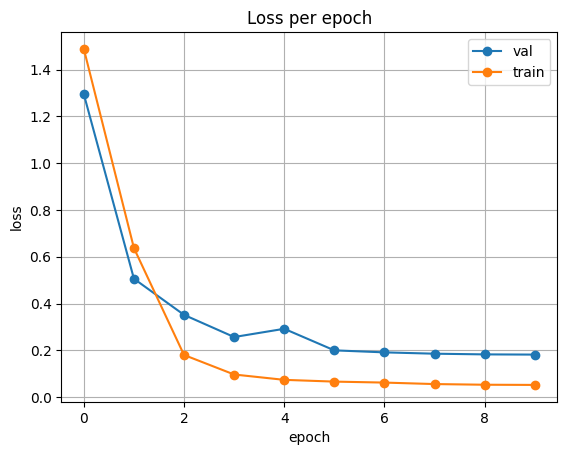

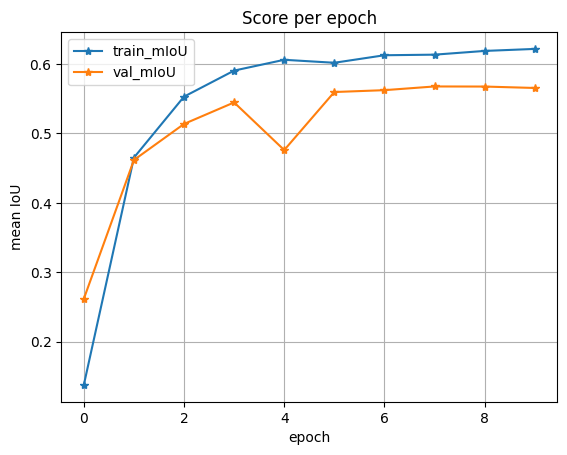

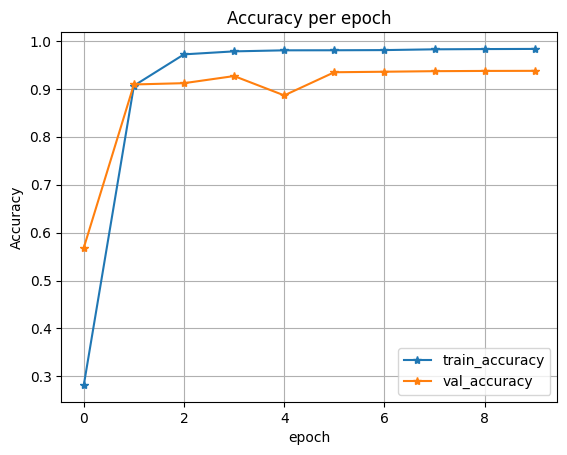

In [34]:
plot_loss(history)
plot_score(history)
plot_acc(history)

<hr>

La función predice una máscara de segmentación a partir de una imagen de entrada utilizando un modelo entrenado y calcula el mIoU, una métrica que mide la superposición entre la máscara predicha y la máscara real.

In [35]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    """
    Realiza la predicción de una máscara de segmentación para una imagen dada,
    y calcula el mIoU (mean Intersection over Union) entre la predicción y la máscara real.

    Args:
    - model: El modelo de segmentación entrenado.
    - image: La imagen de entrada sobre la que se hará la predicción.
    - mask: La máscara de segmentación real para la imagen.
    - mean: Lista con la media para normalizar los canales de la imagen.
    - std: Lista con la desviación estándar para normalizar los canales de la imagen.

    Returns:
    - masked: La predicción de la máscara de segmentación.
    - score: El mIoU entre la predicción y la máscara real.
    - output: La salida del modelo con las probabilidades para cada clase.
    """

    # Cambiar el modelo al modo de evaluación
    model.eval()

    # Normalización opcional de la imagen (comentada en este caso)
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)

    # Enviar la imagen y la máscara al dispositivo (GPU o CPU)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        # Paso hacia adelante del modelo para generar la predicción
        output = model(image)

        # Extraer las dimensiones de la salida
        a, b, c, d = output.shape

        # Calcular el mIoU (mean Intersection over Union) entre la predicción y la máscara
        score = mIoU(output, mask)

        # Tomar la clase con mayor probabilidad en la salida (argmax) para obtener la máscara predicha
        masked = torch.argmax(output, dim=1)

        # Mover la máscara predicha a la CPU y eliminar dimensiones innecesarias
        masked = masked.cpu().squeeze(0)

    # Retornar la máscara predicha, el mIoU y la salida original del modelo
    return masked, score, output.permute(0, 2, 3, 1)  # Cambiar el orden de los ejes para visualización

La función predice una máscara de segmentación para una imagen y calcula la precisión a nivel de píxel, que mide qué porcentaje de los píxeles se han clasificado correctamente en comparación con la máscara real.

In [36]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Realiza la predicción de una máscara de segmentación para una imagen dada,
    y calcula la precisión a nivel de píxel entre la predicción y la máscara real.

    Args:
    - model: El modelo de segmentación entrenado.
    - image: La imagen de entrada sobre la que se hará la predicción.
    - mask: La máscara de segmentación real para la imagen.
    - mean: Lista con la media para normalizar los canales de la imagen (opcional).
    - std: Lista con la desviación estándar para normalizar los canales de la imagen (opcional).

    Returns:
    - masked: La predicción de la máscara de segmentación.
    - acc: La precisión a nivel de píxel entre la predicción y la máscara real.
    """

    # Cambiar el modelo al modo de evaluación
    model.eval()

    # Enviar la imagen y la máscara al dispositivo (GPU o CPU)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        # Paso hacia adelante del modelo para generar la predicción
        output = model(image)

        # Calcular la precisión a nivel de píxel entre la predicción y la máscara real
        acc = pixel_accuracy(output, mask)

        # Tomar la clase con mayor probabilidad en la salida (argmax) para obtener la máscara predicha
        masked = torch.argmax(output, dim=1)

        # Mover la máscara predicha a la CPU y eliminar dimensiones innecesarias
        masked = masked.cpu().squeeze(0)

    # Retornar la máscara predicha y la precisión a nivel de píxel
    return masked, acc

El código extrae un lote de datos de validación, hace predicciones de segmentación, transforma tensores a formatos compatibles (NumPy), verifica la disponibilidad de CUDA (para saber si se puede utilizar una GPU), y finalmente visualiza los resultados. Es relevante en un contexto de segmentación de imágenes, ya que involucra el proceso completo desde la obtención de los datos hasta la evaluación y visualización de los resultados de segmentación.

0.5654629752996391
CUDA disponible: False
El tensor está en el dispositivo: cpu


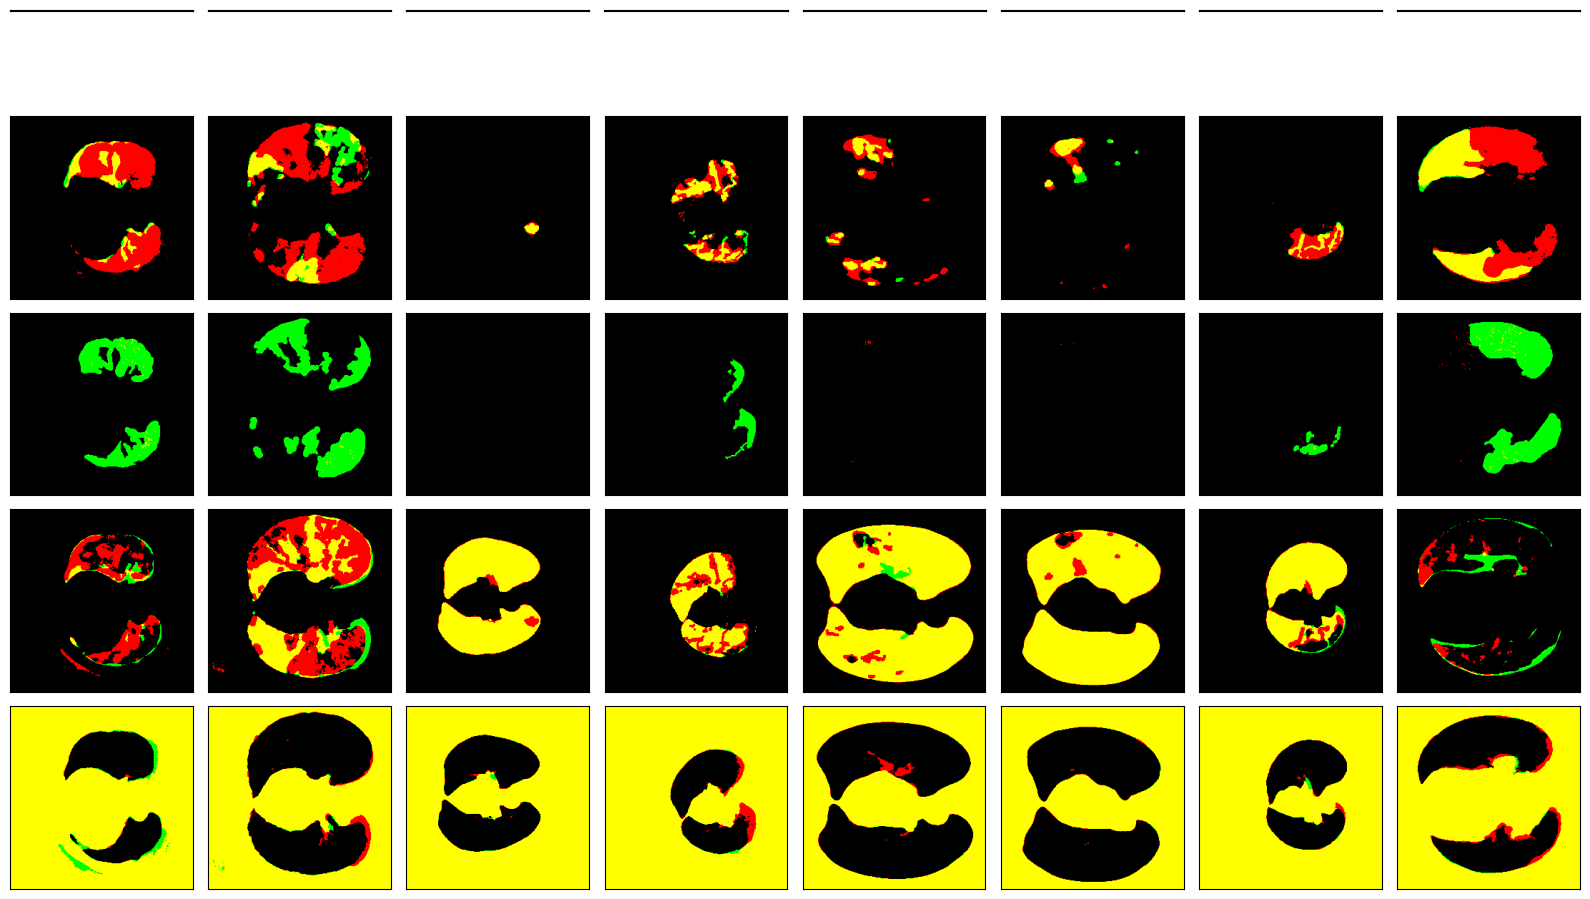

In [37]:
# Obtén los datos del val_dataloader
image, mask = next(iter(val_dataloader))

# Mover los tensores a la CPU si es necesario y convertir a numpy
image_np = image.cpu().numpy() if image.is_cuda else image.numpy()  # Transformar a NumPy
mask_np = mask.cpu().numpy() if mask.is_cuda else mask.numpy()      # Transformar a NumPy

# Ejecutar predicción y obtener máscaras y puntuaciones
pred_mask, score, output = predict_image_mask_miou(model, image, mask)
print(score)
# Convertir la máscara a one-hot encoding y mover a NumPy
semantic_map = mask_to_onehot(torch.unsqueeze(mask, -1).cpu().numpy(), palette)

# Verificación de si CUDA está disponible
print("CUDA disponible:", torch.cuda.is_available())

# Establecer dispositivo (opcional, si se trabaja en CPU directamente)
device = torch.device('cpu')

# Ejemplo de operaciones con tensores en el dispositivo (CPU)
x = torch.rand(5, 5).to(device)  # Mover tensor al CPU
print(f"El tensor está en el dispositivo: {x.device}")

# Función de visualización
visualize(image_np, semantic_map, pred_batch=output)

<hr>

Define una función llamada miou_score que calcula el mean Intersection over Union (mIoU), una métrica común para evaluar el rendimiento de modelos de segmentación de imágenes. El objetivo es aplicar el modelo entrenado a un conjunto de pruebas (test_set) y obtener el mIoU para cada imagen.

In [38]:
def miou_score(model, test_set):
    """
    Calcula el puntaje mIoU (mean Intersection over Union) para un conjunto de pruebas dado.

    Args:
    - model: El modelo entrenado que se utilizará para predecir las máscaras de segmentación.
    - test_set: El conjunto de pruebas, que es un iterable de pares (imagen, máscara).

    Returns:
    - score_iou: Una lista con los puntajes mIoU para cada imagen en el conjunto de pruebas.
    """

    # Lista para almacenar los puntajes mIoU de cada imagen
    score_iou = []

    # Iterar sobre cada imagen y su correspondiente máscara en el conjunto de pruebas
    for i, data in enumerate(tqdm(test_set)):  # tqdm se utiliza para mostrar el progreso de la iteración
        img, mask = data  # Extraer la imagen y la máscara de segmentación
        # Predecir la máscara y calcular el mIoU utilizando el modelo
        pred_mask, score, output = predict_image_mask_miou(model, img, mask)
        # Guardar el puntaje mIoU en la lista
        score_iou.append(score)

    # Devolver la lista de puntajes mIoU
    return score_iou

In [39]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.5654629752996391]

In [40]:
# Elimina las variables que contienen las imágenes y máscaras de entrenamiento de la memoria.
# Esto libera la memoria que ocupaban estos objetos, útil cuando ya no son necesarios.
del train_images
del train_masks

In [41]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    """
    Realiza una predicción sobre una imagen usando el modelo proporcionado.
    Aplica preprocesamiento a la imagen, como la normalización, antes de realizar la predicción.

    Parámetros:
    model: El modelo de segmentación entrenado.
    image: La imagen de entrada para realizar la predicción.
    mean: Valores de media para la normalización (por defecto es [0.485]).
    std: Valores de desviación estándar para la normalización (por defecto es [0.229]).

    Retorna:
    output: El resultado de la predicción, permutado para obtener la forma correcta (H, W, C).
    """

    # Aplica la transformación a la imagen: convierte a tensor y normaliza usando los valores de media y desviación estándar.
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)

    # Coloca el modelo en modo de evaluación (desactiva el dropout y batch normalization)
    model.eval()

    # Mueve el modelo y la imagen al dispositivo (CPU o GPU)
    model.to(device); image = image.to(device)

    # Realiza la predicción sin calcular gradientes para ahorrar memoria
    with torch.no_grad():
        # Añade una dimensión adicional a la imagen para que tenga la forma correcta para el modelo
        output = model(torch.unsqueeze(image, 1))

        # Aplica softmax a lo largo de la dimensión de las clases (dim=1) para obtener probabilidades
        output = nn.Softmax(dim=1)(output)

    # Permuta el output para que tenga la forma (batch_size, H, W, C)
    return output.permute(0, 2, 3, 1)

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


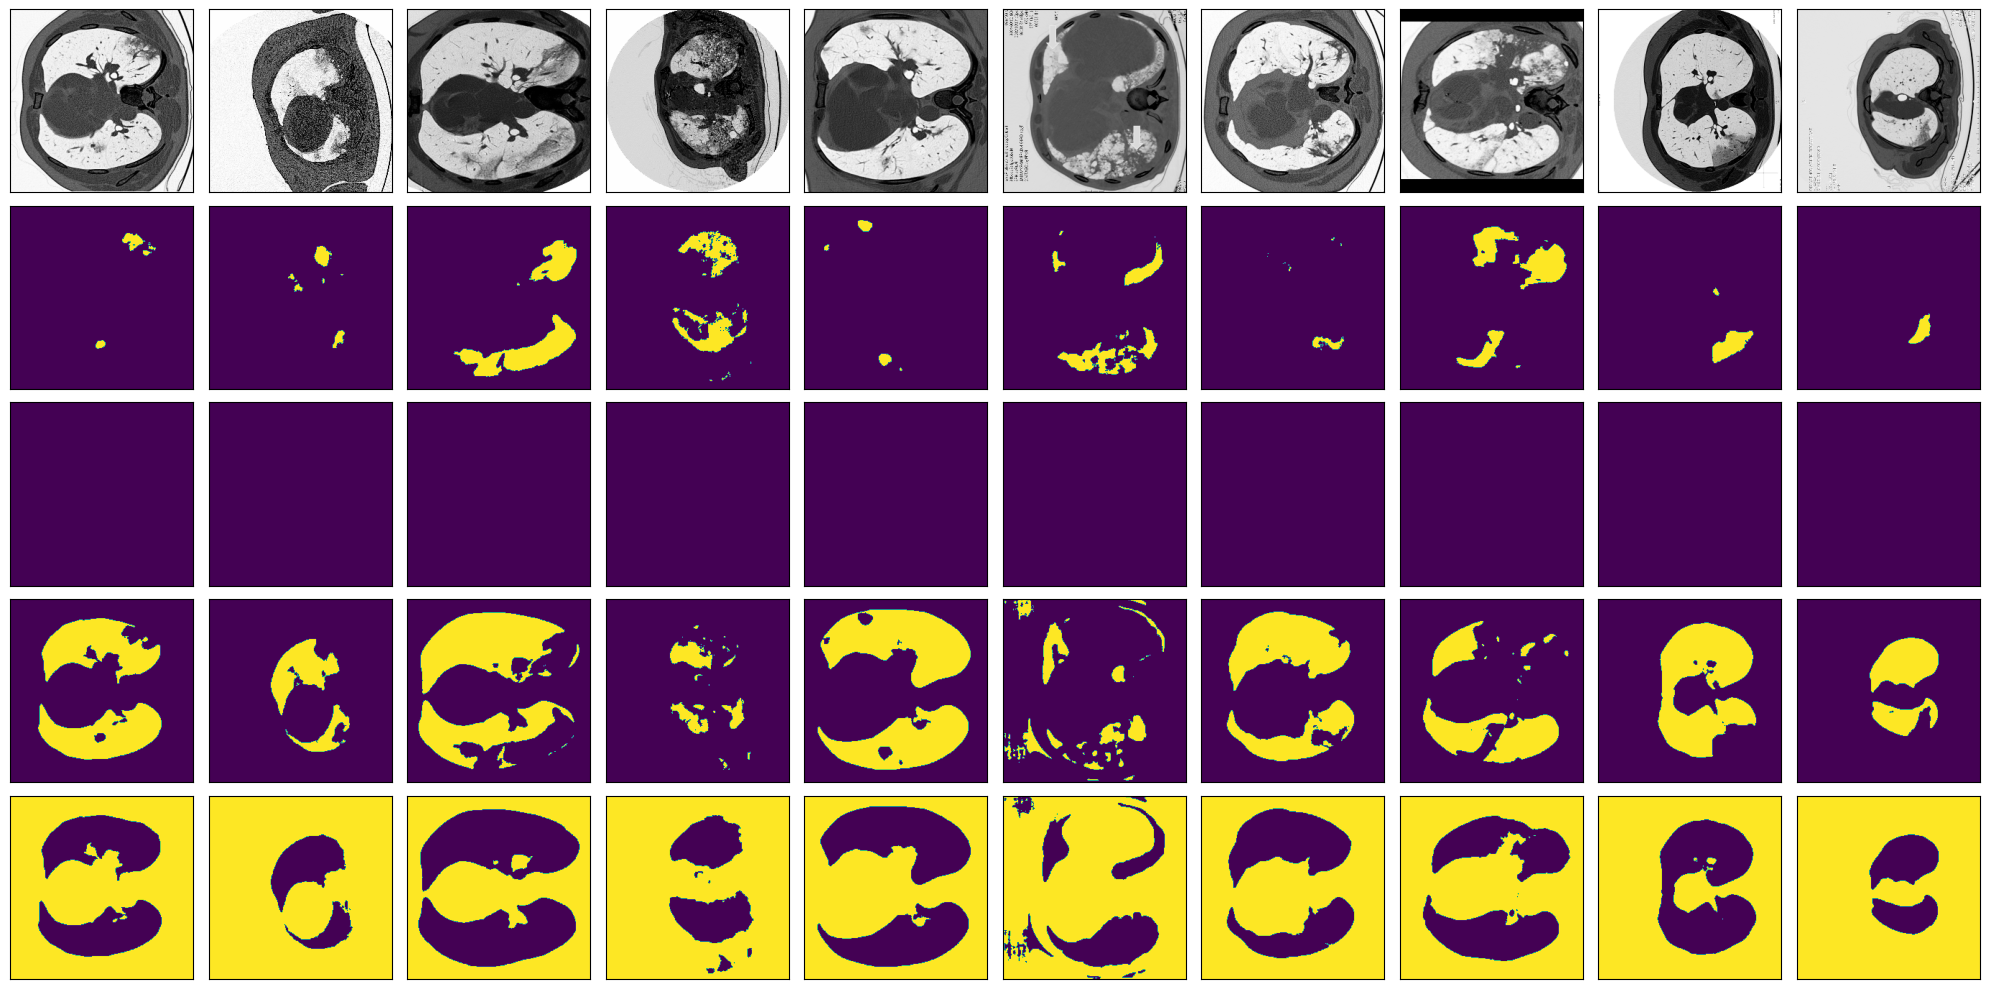

In [42]:
# Aplica las transformaciones de validación (val_augs) a cada imagen en test_images_medseg
# y las apila en un solo array (batch de imágenes). Cada imagen es transformada según las
# augumentaciones definidas en 'val_augs'.
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)

# Imprime la forma del batch de imágenes convertido a un tensor de PyTorch.
print(torch.from_numpy(image_batch).shape)

# Imprime la forma de una imagen individual del batch (en este caso, la imagen con índice 'i').
print(image_batch[i].shape)

# Inicializa un array de ceros llamado 'output' con el tamaño de 10 imágenes y dimensiones de 256x256x4
# (esto es porque se espera una salida con 4 canales, posiblemente para segmentación multiclas).
output = np.zeros((10, 256, 256, 4))

# Recorre el batch de 10 imágenes, llamando a la función 'test_predict' en cada imagen
# y almacenando la predicción en el array 'output'.
for i in range(10):
    output[i] = test_predict(model, image_batch[i])

# Imprime la forma del array 'output', que debería ser (10, 256, 256, 4),
# confirmando que tiene la forma esperada para las predicciones.
print(output.shape)

# Aplica una máscara de predicción donde los valores del output mayores a 0.5 se consideran 1 (True),
# lo que puede ser útil para obtener un mapa binario de predicciones.
test_masks_prediction = output > 0.5

# Llama a la función 'visualize' para mostrar las imágenes originales y sus máscaras de predicción
# correspondientes, con un número de muestras igual al tamaño del dataset de imágenes de prueba.
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [43]:
import scipy

# Redimensiona las máscaras de predicción a su tamaño original. La función 'zoom' de scipy.ndimage
# se usa para realizar un cambio de tamaño en las predicciones de máscara.
# Aquí, se están duplicando las dimensiones espaciales (altura y ancho) de las máscaras
# utilizando un factor de 2 (de 1x a 2x), mientras que la dimensión de clase se mantiene igual (1).
# El parámetro 'order=0' indica que se usa la interpolación de vecinos más cercanos (sin suavizado).
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)

# Imprime la forma del array de máscaras de predicción redimensionadas para verificar que
# tiene el tamaño esperado después del cambio de tamaño.
test_masks_prediction_original_size.shape


(10, 512, 512, 2)

In [44]:
import pandas as pd

# Crea un DataFrame de pandas a partir de los datos de predicción de las máscaras redimensionadas.
# Los datos se estructuran en dos columnas: 'Id' y 'Predicted'.
# - 'Id': Un identificador único para cada predicción, generado como un rango de números del 0 al número de predicciones.
# - 'Predicted': Los valores de las predicciones de las máscaras, aplanados y convertidos a enteros.
df = pd.DataFrame(
    data=np.stack((
        np.arange(len(test_masks_prediction_original_size.ravel())),  # Genera una secuencia de IDs únicos
        test_masks_prediction_original_size.ravel().astype(int)  # Aplana las predicciones y las convierte a enteros
    ), axis=-1),
    columns=['Id', 'Predicted']  # Nombres de las columnas
)

# Configura la columna 'Id' como índice y guarda el DataFrame en un archivo CSV llamado 'sub.csv'.
df.set_index('Id').to_csv('sub.csv')

### Subir a Kaggle

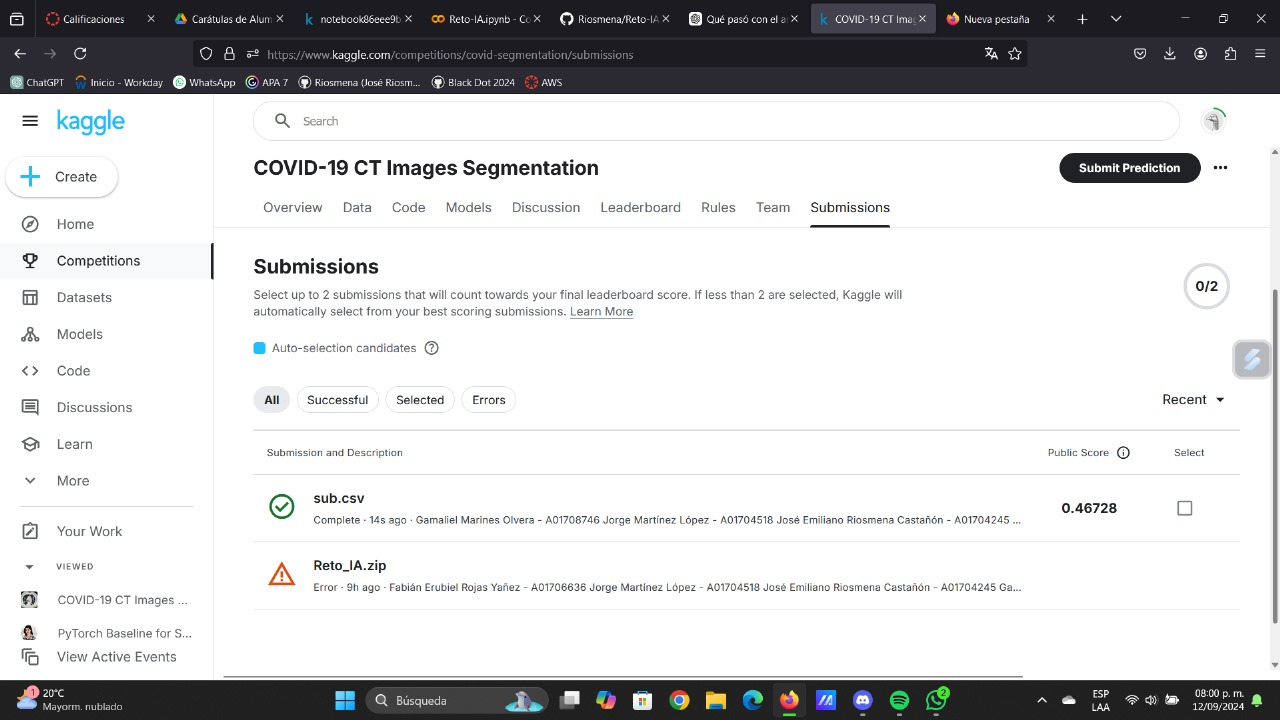

## Resources

* [UWMGI: 2.5D [Infer] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-infer-pytorch)

* [TensorFlow documentation style guide](https://www.tensorflow.org/community/contribute/docs_style)
* [Google developer documentation style guide](https://developers.google.com/style/highlights)